In [1]:
CONSUMER_KEY = 'YOUR_KEY'
CONSUMER_SECRET = 'YOUR_SECRET'

ACCESS_TOKEN_KEY = 'YOUR_TOKEN'
ACCESS_TOKEN_SECRET = 'YOUR_SECRET'

import re
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
    
from tweepy import API
from tweepy import Cursor
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener


auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
api = API(auth)

In [2]:
# class responsible to authenticate user
class TwitterAuthenticator():
    
    def authenticate_user(self):
        # authenticate code
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
        return auth

In [3]:
# class to extract timeline tweets
class TwitterClient():
    
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_user() 
        self.twitter_client = API(self.auth)
        # identify user timeline for specified users
        self.twitter_user = twitter_user
    
    def get_twitter_client_api(self):
        return self.twitter_client    
    
    # build function on how many tweets to extract
    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

In [4]:
# class responsible for streaming the tweets
class TwitterStreamer(TwitterAuthenticator):
    ''' Class for streaming and processing live tweets'''
    
    # def __int__(self):
    #      self.twitter_autenticator = TwitterAuthenticator()
    
    # class method1
    def stream_tweets(self, fetched_tweets_filename, hashtag_list):
        '''
        Handels twitter authentication and connection
        this method handels authentication and connection with twitter streaming API
        
        Parameters
        ----------
        fetched_tweets_filename : string
            pass filename to save file in directory.
        hashtag_list : list
            list of hashtags to filter streaming data.

        Returns
        -------
        streaming tweets filtered with target information.

        '''

        # build listener object
        listen = TwitterListener(fetched_tweets_filename)
        auth = TwitterAuthenticator().authenticate_user() 
        
        # create twitter stream
        stream_data = Stream(auth, listen)
        
        # you filter the stream and obtain filtered data
        stream_data.filter(track=hashtag_list)

In [5]:
# set class
class TwitterListener(StreamListener):
    '''Basic listener class, printing recieved tweets'''

    # build constructor that can save fetched tweets
    def __init__(self, fetched_tweets_filename):
        # class variable
        self.fetched_tweets_filename = fetched_tweets_filename

    # print error or status
    def on_data(self, data):
        try:
            print(data)
            # append data
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
                return True
        except BaseException as e:
            print('Error on data: {}'.format(str(e)))
        return True
                
    # print data
    def on_error(self, status):
        if status == 420:
            # return message if rate limit has been reached
            return False
        print(status)

In [6]:
# class to analyze tweets
class TweetAnalyzer():
    
    # data pre-processing
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    # sentiment analysis
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            # positive
            return 1
        elif analysis.sentiment.polarity == 0:
            # neutral
            return 0
        else:
            # negative
            return -1
    
    def tweets_to_dataframe(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])

        return df

Average length of tweets: 128.32
number of likes for the most liked tweet: 4239330
number of retweets for most retweeted tweet: 516102
                                              tweets                   id  \
0  RT @POTUS: Everyone who wants a vaccine should...  1358465618501136384   
1  RT @POTUS: Last year, Michele lost her job bec...  1358084646685319170   
2  RT @POTUS: This morning, I met with House Demo...  1357840281069113355   
3  RT @POTUS: America is back. Diplomacy is back....  1357773974550306818   
4  RT @POTUS: This afternoon, I’m visiting the @S...  1357414638510616579   
5  RT @POTUS: Extending the moratorium on evictio...  1357376416380256258   
6  RT @POTUS: Let me be clear: The risk in this m...  1357119042327359488   
7  RT @POTUS: Officer Brian Sicknick was a hero w...  1357052766720557066   
8  RT @POTUS: No one should lose their home in th...  1356962956647538688   
9  RT @POTUS: It’s long past time we raise the mi...  1356682004130062339   

   len           

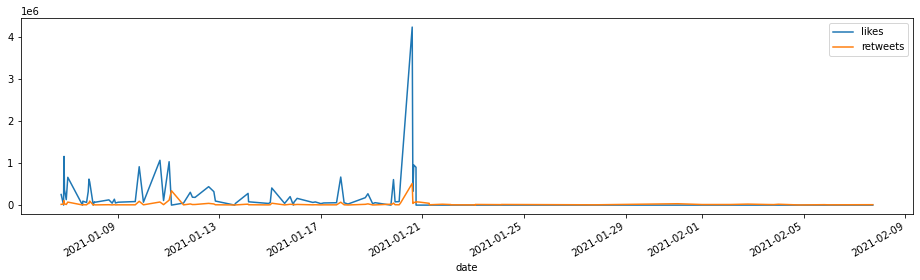

In [7]:
if __name__ == "__main__":
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="JoeBiden", count=100)

    # import all tweets to df
    df = tweet_analyzer.tweets_to_dataframe(tweets)
    # add sentiment column
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

    # Get average length over all tweets:
    print('Average length of tweets: {}'.format(np.mean(df['len'])))

    # Get the number of likes for the most liked tweet:
    print('number of likes for the most liked tweet: {}'.format(np.max(df['likes'])))

    # Get the number of retweets for the most retweeted tweet:
    print('number of retweets for most retweeted tweet: {}'.format(np.max(df['retweets'])))
    
    print(df.head(10))


    # Layered Time Series:
    time_likes = pd.Series(data=df['likes'].values, index=df['date'])
    time_likes.plot(figsize=(16, 4), label="likes", legend=True)

    time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
    plt.show()